In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [5]:
# Load preprocessed data
artifacts_dir = '../artifacts'

print("Loading preprocessed data for clustering analysis...")
data = joblib.load(os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
vectorizer = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))

# Extract data components - combine all splits for clustering
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']

# Combine all data for clustering (unsupervised learning)
from scipy.sparse import vstack
X_all = vstack([X_train, X_val, X_test])
y_all = pd.concat([y_train, y_val, y_test], ignore_index=True)

print(f"Combined dataset for clustering: {X_all.shape}")
print(f"Total documents: {len(y_all)}")
print(f"Feature dimensions: {X_all.shape[1]}")
print(f"True labels available for evaluation: {len(class_names)} classes")

Loading preprocessed data for clustering analysis...
Combined dataset for clustering: (2464, 5000)
Total documents: 2464
Feature dimensions: 5000
True labels available for evaluation: 13 classes


In [6]:
# Determine optimal number of clusters using multiple methods
print("Analyzing optimal number of clusters...")

# Test range of cluster numbers
k_range = range(2, 21)  # Test 2 to 20 clusters
inertias = []
silhouette_scores = []

print("Computing clustering metrics for different k values...")
for k in k_range:
    print(f"Testing k={k}...", end=' ')
    
    # Fit k-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_all)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_all, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"Silhouette: {silhouette_avg:.3f}")

print("\nCluster analysis completed!")

Analyzing optimal number of clusters...
Computing clustering metrics for different k values...
Testing k=2... Silhouette: 0.022
Testing k=3... Silhouette: 0.024
Testing k=4... Silhouette: 0.027
Testing k=5... Silhouette: 0.028
Testing k=6... Silhouette: 0.031
Testing k=7... Silhouette: 0.034
Testing k=8... Silhouette: 0.027
Testing k=9... Silhouette: 0.033
Testing k=10... Silhouette: 0.036
Testing k=11... Silhouette: 0.034
Testing k=12... Silhouette: 0.033
Testing k=13... Silhouette: 0.039
Testing k=14... Silhouette: 0.039
Testing k=15... Silhouette: 0.040
Testing k=16... Silhouette: 0.041
Testing k=17... Silhouette: 0.043
Testing k=18... Silhouette: 0.043
Testing k=19... Silhouette: 0.045
Testing k=20... Silhouette: 0.047

Cluster analysis completed!


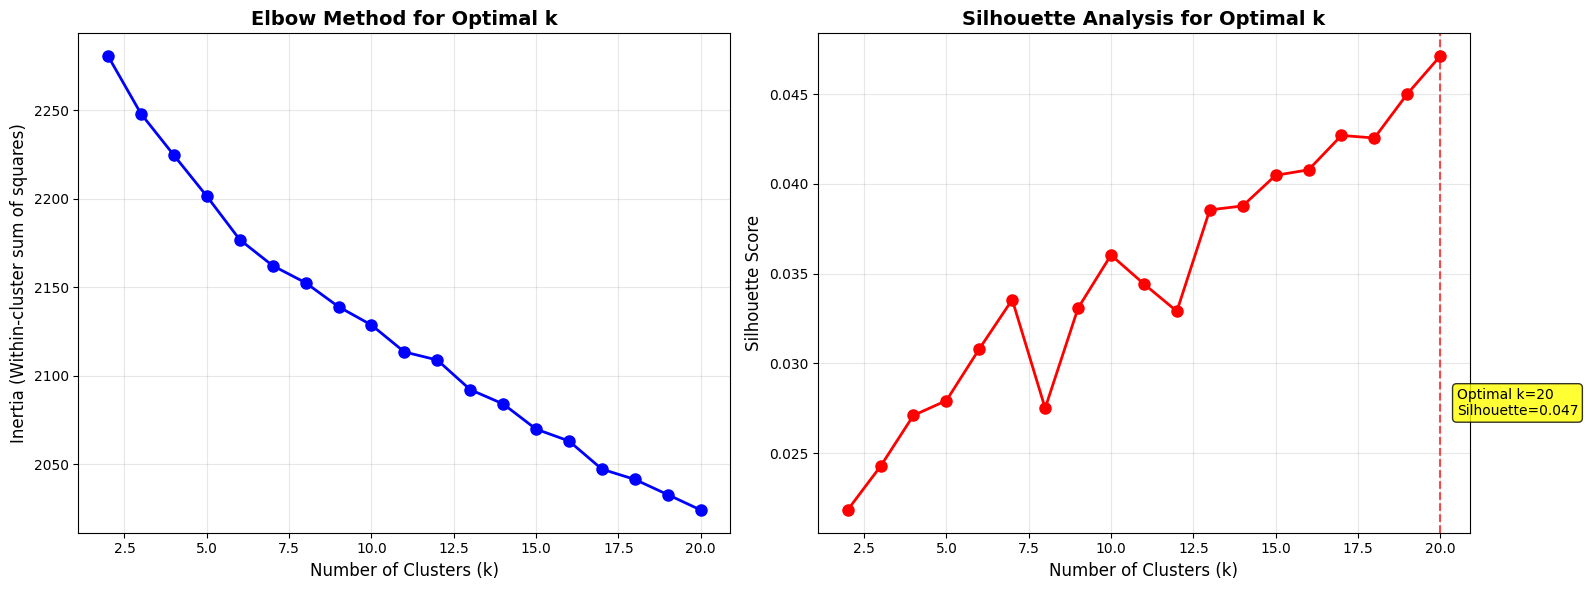

Optimal number of clusters based on Silhouette Score: 20
Maximum Silhouette Score: 0.0471


In [7]:
# Plot elbow curve and silhouette analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Elbow method
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette analysis
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Highlight optimal k based on silhouette score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)
ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7)
ax2.text(optimal_k_silhouette + 0.5, max_silhouette - 0.02, 
         f'Optimal k={optimal_k_silhouette}\nSilhouette={max_silhouette:.3f}', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")
print(f"Maximum Silhouette Score: {max_silhouette:.4f}")

In [8]:
# Compare with the number of true medical specialties
true_k = len(class_names)
print(f"\nComparison with true medical specialties:")
print(f"Number of true medical specialties: {true_k}")
print(f"Optimal k from silhouette analysis: {optimal_k_silhouette}")

# Test both the optimal k and the true number of specialties
k_values_to_test = [optimal_k_silhouette, true_k]
if optimal_k_silhouette == true_k:
    k_values_to_test = [optimal_k_silhouette]

print(f"\nWill analyze clustering results for k = {k_values_to_test}")


Comparison with true medical specialties:
Number of true medical specialties: 13
Optimal k from silhouette analysis: 20

Will analyze clustering results for k = [20, 13]


In [9]:
# Implement k-means with optimal k
final_k = optimal_k_silhouette
print(f"Implementing k-Means clustering with k={final_k}...")

# Fit final k-means model
final_kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=20)
cluster_labels = final_kmeans.fit_predict(X_all)

# Calculate final metrics
final_silhouette = silhouette_score(X_all, cluster_labels)
final_inertia = final_kmeans.inertia_

print(f"Clustering completed!")
print(f"Final silhouette score: {final_silhouette:.4f}")
print(f"Final inertia: {final_inertia:.2f}")
print(f"Cluster sizes: {Counter(cluster_labels)}")

Implementing k-Means clustering with k=20...
Clustering completed!
Final silhouette score: 0.0476
Final inertia: 2021.84
Cluster sizes: Counter({np.int32(4): 335, np.int32(2): 272, np.int32(10): 221, np.int32(1): 170, np.int32(12): 147, np.int32(14): 141, np.int32(3): 137, np.int32(5): 131, np.int32(17): 122, np.int32(13): 114, np.int32(18): 114, np.int32(6): 85, np.int32(16): 84, np.int32(9): 81, np.int32(15): 68, np.int32(19): 63, np.int32(8): 57, np.int32(11): 43, np.int32(7): 40, np.int32(0): 39})


In [ ]:
# Analyze cluster composition with respect to true medical specialties
print("CLUSTER COMPOSITION ANALYSIS")
print("=" * 50)

# Create a DataFrame for analysis
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'true_specialty': y_all
})

# Calculate cluster-specialty crosstab
crosstab = pd.crosstab(cluster_df['cluster'], cluster_df['true_specialty'], 
                      margins=True, margins_name='Total')

print("\nCluster vs Medical Specialty Cross-tabulation:")
print(crosstab)

# Calculate purity of each cluster
cluster_purity = {}
for cluster_id in range(final_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_specialties = y_all[cluster_mask]
    most_common_specialty = cluster_specialties.mode()[0]
    purity = (cluster_specialties == most_common_specialty).mean()
    cluster_purity[cluster_id] = {
        'dominant_specialty': most_common_specialty,
        'purity': purity,
        'size': len(cluster_specialties)
    }

print(f"\nCluster Purity Analysis:")
for cluster_id, info in cluster_purity.items():
    print(f"Cluster {cluster_id}: {info['dominant_specialty']} ")
    print(f"  Purity: {info['purity']:.3f} ({info['size']} documents)")